### Gadi path set-up¶

In [1]:
import os
import pathlib

nci_user_name = "abc123"   ### change this to your NCI user name
work_path = pathlib.Path("/g/data/nm05/workspace/").joinpath(nci_user_name)
musgraves_edis_path = pathlib.Path("/g/data/nm05/workshop_data/Musgraves_edis")

### Comment these three lines below, which are here for pre-workshop testing
work_path = pathlib.Path().home().joinpath("aurora_test_folder")
work_path.mkdir(parents=True, exist_ok=True)
musgraves_edis_path = pathlib.Path().home().joinpath("software", "irismt", "mt_examples", "data", "Musgraves_edis")

os.chdir(work_path)
target_folder = work_path

# Processing Example: Musgraves Dataset

Steps:

0. [X] Import packages, set paths, check versions, configure variables
1. [X] Review directory structure and interact with the dataset
2. [X] Select a test station and remote reference
3. [X] Process with aurora (SS)
4. [X] Process with aurora RR
5. [X] Compare Transfer Functions
6. [ ] Run on HPC 

## 0. Import packages

In [2]:
import pandas as pd
import pathlib
import socket
import warnings

from aurora.config.config_creator import ConfigCreator
from aurora.config import BANDS_TEST_FAST_FILE
from aurora.general_helper_functions import BAND_SETUP_PATH
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset
from mth5.mth5 import MTH5
from mtpy import MT
from mtpy import MTData
from mt_metadata.transfer_functions.processing.aurora.channel_nomenclature import CHANNEL_MAPS

warnings.filterwarnings('ignore')

### Check versions

In [3]:
import aurora
import mt_metadata
import mth5

print(f"aurora.__version__ {aurora.__version__}")
print(f"mt_metadata.__version__ {mt_metadata.__version__}")
print(f"mth5.__version__ {mth5.__version__}")

aurora.__version__ 0.3.11
mt_metadata.__version__ 0.3.3
mth5.__version__ 0.4.1


### Set some Paths
- this is a little overdone

In [4]:
hostname = socket.gethostname()
print(f"hostname: {hostname}")
if "gadi" in hostname:
    my80_path = pathlib.Path("/g/data/my80")
elif hostname == "namazu":
    my80_path = pathlib.Path("/home/kkappler/data/gadi/g/data/my80")
    
au_scope_mt_collection_path = my80_path.joinpath("AuScope_MT_collection")
auslamp_path = au_scope_mt_collection_path.joinpath("AuScope_AusLAMP")
musgraves_path = auslamp_path.joinpath("Musgraves_APY")
data_dir = musgraves_path
assert data_dir.exists()

hostname: namazu


## 1. Review Directory Structure:

The Musgraves dataset is organized by Territory (NT, SA, WA), and within each territory there are levels 0, 1, and 2. 

Use NT as an example to look at the level structure:

There are two folders of interest for this exercise, the MTH5 ones:
- level_0/Concatenated_Time_Series_MTH5_per_run
- level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5

We will abbreviate these as level 0 and 1 for indexing the hdf5s.

In [5]:
def get_musgraves_availability_df(data_dir):
    """
    recusively search for h5 files in data_dir, tabulate and return a dataframe
    """
    all_mth5_files = list(data_dir.rglob("*h5"))
    num_mth5 = len(all_mth5_files)
    print(f"Found {num_mth5} h5 files")
    levels = num_mth5 * [""]
    station_ids = num_mth5 * [""]
    territories = num_mth5 * [""]
    paths = num_mth5 * [""]

    for i_filepath, filepath in enumerate(all_mth5_files):
        levels[i_filepath] = str(filepath).split("level_")[1][0]
        station_ids[i_filepath] = filepath.stem
        territories[i_filepath] = str(filepath).split("Musgraves_APY/")[1][0:2]
        paths[i_filepath] = filepath
    df_dict = {"level": levels, "territory": territories, "station_id": station_ids, "path": paths}
    df = pd.DataFrame(data=df_dict)

    return df

In [6]:
availability_df = get_musgraves_availability_df(data_dir)
availability_df

Found 6 h5 files


,level,territory,station_id,path
0,1,NT,WANT38,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
1,1,NT,SA349,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
2,1,SA,SA225-2,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
3,1,SA,SA275,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
4,1,SA,SA300,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
5,1,SA,SA227,/home/kkappler/data/gadi/g/data/my80/AuScope_M...


### Or ... Use pathlinb to index the hd5 files


In [7]:
all_mth5_files = data_dir.rglob("*h5")
all_mth5_files_list = list(all_mth5_files)

In [8]:
num_mth5 = len(all_mth5_files_list)
print(f"Found {num_mth5} h5 files")
# print(list(all_mth5_files))

Found 6 h5 files


### Make a table of these files, extracting reference properties: "level", "territory", "station_id"

In [9]:
levels = num_mth5 * [""]
station_ids = num_mth5 * [""]
territories = num_mth5 * [""]
paths = num_mth5 * [""]

for i_filepath, filepath in enumerate(all_mth5_files_list):
    levels[i_filepath] = str(filepath).split("level_")[1][0]
    station_ids[i_filepath] = filepath.stem
    territories[i_filepath] = str(filepath).split("Musgraves_APY/")[1][0:2]
    paths[i_filepath] = filepath

In [10]:
df_dict = {"level":levels, "territory":territories, "station_id": station_ids, "path":paths}
df = pd.DataFrame(data=df_dict)
df

,level,territory,station_id,path
0,1,NT,WANT38,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
1,1,NT,SA349,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
2,1,SA,SA225-2,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
3,1,SA,SA275,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
4,1,SA,SA300,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
5,1,SA,SA227,/home/kkappler/data/gadi/g/data/my80/AuScope_M...


### Take a look at the distribution of the data

In [11]:
df[["level", "territory",]].value_counts()

level  territory
1      SA           4
       NT           2
Name: count, dtype: int64

### Northern Territory (NT) has only two stations so we can use it for some testing

In [12]:
nt_df = df[(df.territory=="NT") & (df.level=="1")]
nt_df

,level,territory,station_id,path
0,1,NT,WANT38,/home/kkappler/data/gadi/g/data/my80/AuScope_M...
1,1,NT,SA349,/home/kkappler/data/gadi/g/data/my80/AuScope_M...


### Open the mth5 files using a dict for tracking who's who

In [13]:
mth5_objs = {x:MTH5() for x in nt_df.station_id}


In [14]:
for i, row in nt_df.iterrows():
    mth5_objs[row.station_id].open_mth5(row.path, "r")

### Take a gander at the structure

In [15]:
mth5_objs["SA349"]

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: AusLAMP_Musgraves
            ---------------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: bz_adjustment
                        -----------------------
                        |- Group: gain_b
                        ----------------
                        |- Group: gain_e
                        ----------------
                        |- Group: gain_eonly
                        --------------------
                    |- Group: fap
                    -------------
                    |- Group: fir
                    -------------
 

### Looks like just one run here

In [16]:
mth5_objs["WANT38"]

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: AusLAMP_Musgraves
            ---------------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: bz_adjustment
                        -----------------------
                        |- Group: gain_b
                        ----------------
                        |- Group: gain_e
                        ----------------
                        |- Group: gain_eonly
                        --------------------
                    |- Group: fap
                    -------------
                    |- Group: fir
                    -------------
 

In [17]:
channel_summaries = {}
for station_id, mth5_obj in mth5_objs.items():
    channel_summary_df = mth5_obj.channel_summary.to_dataframe()
    channel_summaries[station_id] = channel_summary_df

In [18]:
channel_summaries["SA349"]

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,none,SA349,1,-25.99472,130.49991,646.0,bx,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,none,SA349,1,-25.99472,130.49991,646.0,by,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,magnetic,90.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,none,SA349,1,-25.99472,130.49991,646.0,bz,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,none,SA349,1,-25.99472,130.49991,646.0,ex,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,electric,0.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,none,SA349,1,-25.99472,130.49991,646.0,ey,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,electric,90.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


In [19]:
channel_summaries["WANT38"]

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,none,WANT38,1,-25.00617,129.00358,731.0,bx,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,none,WANT38,1,-25.00617,129.00358,731.0,by,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,magnetic,90.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,none,WANT38,1,-25.00617,129.00358,731.0,bz,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,none,WANT38,1,-25.00617,129.00358,731.0,ex,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,electric,0.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,none,WANT38,1,-25.00617,129.00358,731.0,ey,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,electric,90.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


We can see that SA349 is from 2017, and WANT38 is from 2016, so we cannot do RR processing here.

In [20]:
mth5_objs.keys()

dict_keys(['WANT38', 'SA349'])

In [21]:
for i,row in nt_df.iterrows():
    station_obj = mth5_objs[row.station_id].get_station(row.station_id, survey="AusLAMP_Musgraves")
    print(i,station_obj)
    
    

0 /Experiment/Surveys/AusLAMP_Musgraves/Stations/WANT38:
    |- Group: 001
    -------------
        --> Dataset: bx
        .................
        --> Dataset: by
        .................
        --> Dataset: bz
        .................
        --> Dataset: ex
        .................
        --> Dataset: ey
        .................
    |- Group: Transfer_Functions
    ----------------------------
1 /Experiment/Surveys/AusLAMP_Musgraves/Stations/SA349:
    |- Group: 001
    -------------
        --> Dataset: bx
        .................
        --> Dataset: by
        .................
        --> Dataset: bz
        .................
        --> Dataset: ex
        .................
        --> Dataset: ey
        .................
    |- Group: Transfer_Functions
    ----------------------------


In [22]:
# for i,row in nt_df.iterrows():
#     station_id = row.station_id
#     run_from_reference = mth5_objs[station_id].from_reference(channel_summaries[station_id].iloc[0].run_hdf5_reference).to_runts(start=channel_summaries[station_id].iloc[0].start.isoformat(), n_samples=360)
#     print(run_from_reference)
#     run_from_reference.plot()

### Close the mth5s

In [23]:
for station_id, mth5_obj in mth5_objs.items():
    print(f"MTH5 file version is {mth5_obj._MTH5__file_version}") 
    mth5_obj.close_mth5()

MTH5 file version is 0.2.0
23:11:15T18:47:54 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/WANT38.h5
MTH5 file version is 0.2.0
23:11:15T18:47:54 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA349.h5


## 2. Select a test station

Station SA300 is referenced in the mtpy example notebook so let's use it.  Based on a list of station combinations provided by Nigel, we will use SA275 as the reference station.

In [24]:
station_combinations = [('SA225-2','SA294','001','001'),
                        ('SA227','SA243','001','001'),
                        #('SA242','SA242','001','001'),  ### SA242 uses WAS352 as RR - we don't have this station
                        ('SA243','SA294','001','001'),
                        ('SA245','SA245','001','001'),
                        ('SA246','SA294','001','001'),  ### SA246 has multiple runs
                        ('SA247','SA294','001','001'),
                        ('SA248','SA275','001','001'),
                        ('SA249','SA275','001','001'),
                        ('SA250','SA275','001','001'),
                        ('SA251','SA275','001','001'),
                        ('SA252','SA275','001','001'),
                        ('SA26W-2','SA275','001','001'),
                        ('SA270','SA294','001','001'),
                        ('SA271','SA294','001','001'),  ### original script uses SA294 for local and remote?
                        ('SA272','SA294','001','001'),
                        ('SA273','SA275','001','001'),  ### original uses SA273 ex,ey,bz SA251 bx,by SA275 RR
                        ('SA274-2','SA294','001','001'), ### SA274 not used
                        ('SA275','SA252','001','001'),
                        ('SA276','SA275','001','001'),
                        ('SA277','SA275','001','001'),
                        ('SA293-2','SA294','001','001'),
                        ('SA294','SA295','001','001'),
                        ('SA295','SA294','001','001'),
                        ('SA296','SA294','001','001'),
                        ('SA297','SA294','001','001'),
                        ('SA298','SA294','001','001'),
                        # ('SA299','SA275','004','001'),  ### SA299 has multiple runs
                        ('SA300','SA275','001','001'),
                        ('SA301','SA275','001','001'),  ### SA271 doesn't overlap - tried SA275 and it worked
                        ('SA319','SA294','001','001'),
                        #('SA320-2','SA320-2','001','001'), ### SA320-2 and SA294 don't have enough overlap
                        ('SA321','SA294','001','001'),
                        ('SA322','SA275','001','001'),
                        ('SA323','SA275','001','001'),
                        ('SA324-2','SA294','001','001'), ### SA324-2 has multiple runs
                        ('SA325-2','SA294','001','001'),
                        ('SA326N','SA275','001','001'),
                        ('SA326S','SA275','001','001'),
                        #('SA344-2','SA344-2','001','001'), ### length of time series section not long enough
                        ('SA345','SA295','001','001'),
                        ('SA346','SA294','001','001'),
                        ('SA347','SA275','001','001'),
                        ('SA348','SA275','001','001'),
                        # ('SA349','SA275','001','001'), # SA349 is grouped under NT
                        ('SA350','SA275','001','001'),
                        ('SA351','SA275','001','001'),
                        ('WA10','WA30','001','001'),
                        ('WA13','WA30','001','001'),
                        ('WA14','WA30','001','001'),
                        ('WA15','WA30','001','001'),
                        ('WA26','WA30','001','001'),
                        ('WA27','WA30','001','001'),
                        ('WA29','WA30','001','001'),
                        ('WA30','WA45','001','001'),
                        ('WA31','WA30','001','001'),
                        ('WA42','WA30','001','001'),
                        #('WA43','WA43','001','001'),  ### original uses SA075 as both local and remote??
                        ('WA44','WA30','001','001'),
                        ('WA45','WA46','001','001'),
                        ('WA46','WA45','001','001'),
                        ('WA47','WA30','001','001'),
                        ('WA54','WA61','001','001'),
                        ('WA55','WA61','001','001'),
                        ('WA56','WA61','001','001'),  ### original uses WA56 and WA30 which don't overlap
                        ('WA57','WA58','001','001'),
                        ('WA58','WA57','001','001'),
                        ('WA60','WA61','001','001'),
                        ('WA61','WA71','001','001'),
                        ('WA62','WA57','001','001'),
                        ('WA63','WA57','001','001'),
                        ('WA64','WA57','001','001'),
                        ('WA65','WA57','001','001'),
                        ('WA66','WA61','001','001'),
                        ('WA67','WA61','001','001'),
                        ('WA68','WA57','001','001'),
                        ('WA69','WA61','001','001'),
                        ('WA70','WA61','001','001'),  ### original uses WA70 ex,ey,bz, WA69 bx,by, WA61 bx,by
                        ('WA71','WA61','001','001'),
                        ('WA72','WA61','001','001'),
                        ('WA73','WA57','001','001'),
                        ('WA74','WA57','001','001'),
                        ('WA75','WA57','001','001'),
                        ('WANT19','WA30','001','001'),
                        ('WANT38','WANT38','001','001'),
                        ('WANT45','WA30','001','001'),
                        ('WASA302','WA30','001','001'),
                        ('WASA327','WA30','001','001')]

#### Define the station, and remote reference if used

In [25]:
station_id = "SA300"
station_row = df[df.station_id==station_id].iloc[0]
print(f"station_row: \n {station_row}")

reference_station_id = "SA275"
reference_row = df[df.station_id==reference_station_id].iloc[0]
print(f"reference_row: \n {reference_row}")


station_row: 
 level                                                         1
territory                                                    SA
station_id                                                SA300
path          /home/kkappler/data/gadi/g/data/my80/AuScope_M...
Name: 4, dtype: object
reference_row: 
 level                                                         1
territory                                                    SA
station_id                                                SA275
path          /home/kkappler/data/gadi/g/data/my80/AuScope_M...
Name: 3, dtype: object


#### Take a look at the Time Series

MTH5 has some built-in tools for time series visualization.  Alternatively you can use your own plotting tools on the underlying xarrays or numpy arrays.  Here we plot data at the run level and at the channel level



#### Take a look at the "Run" level

23:11:15T18:47:54 | WARNING | line:645 |mth5.timeseries.run_ts | validate_metadata | start time of dataset 2017-08-19T01:00:00+00:00 does not match metadata start 2017-08-19T00:00:00+00:00 updating metatdata value to 2017-08-19T01:00:00+00:00
23:11:15T18:47:54 | WARNING | line:658 |mth5.timeseries.run_ts | validate_metadata | end time of dataset 2017-08-19T01:05:59+00:00 does not match metadata end 2017-08-23T23:59:59.999999+00:00 updating metatdata value to 2017-08-19T01:05:59+00:00
RunTS Summary:
	Survey:      0
	Station:     SA300
	Run:         1
	Start:       2017-08-19T01:00:00+00:00
	End:         2017-08-19T01:05:59+00:00
	Sample Rate: 1.0
	Components:  ['bx', 'by', 'bz', 'ex', 'ey']
23:11:15T18:47:55 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA300.h5


,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,none,SA300,1,-26.95164,129.92562,563.0,bx,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,432000,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,none,SA300,1,-26.95164,129.92562,563.0,by,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,432000,1.0,magnetic,90.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,none,SA300,1,-26.95164,129.92562,563.0,bz,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,432000,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,none,SA300,1,-26.95164,129.92562,563.0,ex,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,432000,1.0,electric,180.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,none,SA300,1,-26.95164,129.92562,563.0,ey,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,432000,1.0,electric,90.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


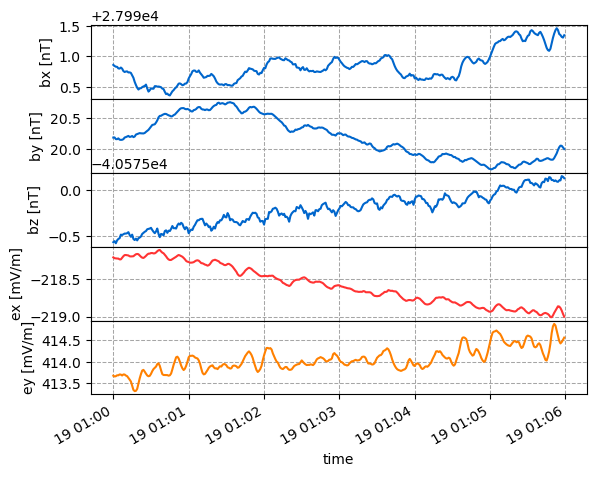

In [26]:
m = mth5.mth5.MTH5()
m.open_mth5(station_row.path)
ch_df = m.channel_summary.to_dataframe()
start = ch_df.iloc[0].start.isoformat()
start = (ch_df.iloc[0].start + pd.Timedelta(hours=1)).isoformat()
n_samples = 360
run_from_reference = m.from_reference(ch_df.iloc[0].run_hdf5_reference).to_runts(start=start, n_samples=n_samples)
print(run_from_reference)
run_from_reference.plot()
m.close_mth5()
ch_df

23:11:15T18:47:56 | WARNING | line:645 |mth5.timeseries.run_ts | validate_metadata | start time of dataset 2017-08-19T01:00:00+00:00 does not match metadata start 2017-08-19T00:00:00+00:00 updating metatdata value to 2017-08-19T01:00:00+00:00
23:11:15T18:47:56 | WARNING | line:658 |mth5.timeseries.run_ts | validate_metadata | end time of dataset 2017-08-19T01:05:59+00:00 does not match metadata end 2017-10-20T23:59:59.999999+00:00 updating metatdata value to 2017-08-19T01:05:59+00:00
RunTS Summary:
	Survey:      0
	Station:     SA275
	Run:         1
	Start:       2017-08-19T01:00:00+00:00
	End:         2017-08-19T01:05:59+00:00
	Sample Rate: 1.0
	Components:  ['bx', 'by', 'bz', 'ex', 'ey']
23:11:15T18:47:56 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA275.h5


,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,none,SA275,1,-27.50302,129.99935,423.0,bx,2017-08-19 00:00:00+00:00,2017-10-20 23:59:59.999999+00:00,5443200,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,none,SA275,1,-27.50302,129.99935,423.0,by,2017-08-19 00:00:00+00:00,2017-10-20 23:59:59.999999+00:00,5443200,1.0,magnetic,90.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,none,SA275,1,-27.50302,129.99935,423.0,bz,2017-08-19 00:00:00+00:00,2017-10-20 23:59:59.999999+00:00,5443200,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,none,SA275,1,-27.50302,129.99935,423.0,ex,2017-08-19 00:00:00+00:00,2017-10-20 23:59:59.999999+00:00,5443200,1.0,electric,0.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,none,SA275,1,-27.50302,129.99935,423.0,ey,2017-08-19 00:00:00+00:00,2017-10-20 23:59:59.999999+00:00,5443200,1.0,electric,90.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


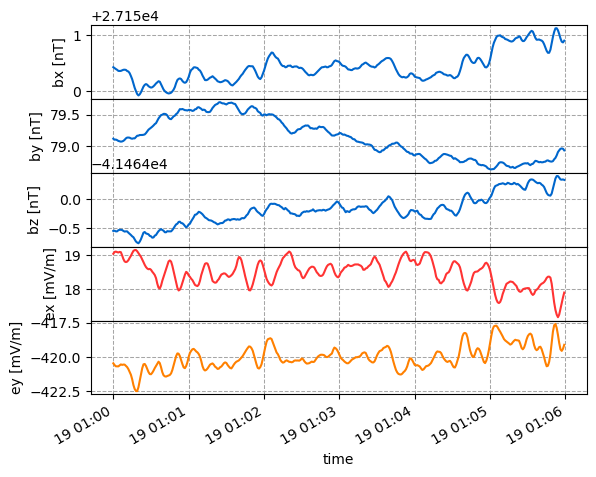

In [27]:
m = mth5.mth5.MTH5()
m.open_mth5(reference_row.path)
ch_df = m.channel_summary.to_dataframe()
start = ch_df.iloc[0].start.isoformat()
start = (ch_df.iloc[0].start + pd.Timedelta(hours=1)).isoformat()
n_samples = 360
run_from_reference = m.from_reference(ch_df.iloc[0].run_hdf5_reference).to_runts(start=start, n_samples=n_samples)
print(run_from_reference)
run_from_reference.plot()
m.close_mth5()
ch_df

#### Take a look at the "Channel" level

Channel Summary:
	Survey:       0
	Station:      SA300
	Run:          1
	Channel Type: Magnetic
	Component:    bx
	Sample Rate:  1.0
	Start:        2017-08-19T00:00:00+00:00
	End:          2017-08-23T23:59:59+00:00
	N Samples:    432000
23:11:15T18:47:56 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA300.h5


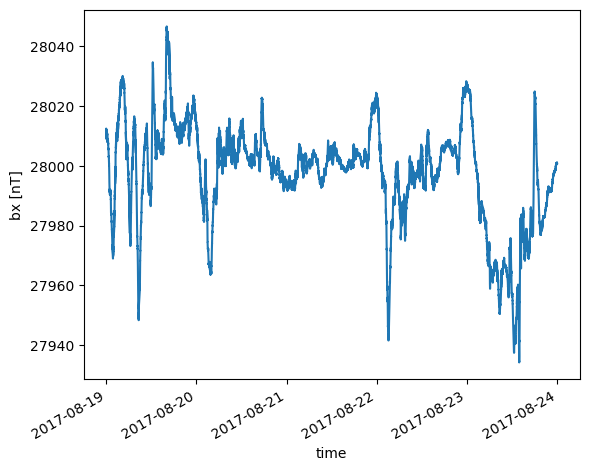

In [28]:
m = mth5.mth5.MTH5()
m.open_mth5(station_row.path)
ch_df = m.channel_summary.to_dataframe()
start = ch_df.iloc[0].start.isoformat()
#start = (ch_df.iloc[0].start + pd.Timedelta(hours=1)).isoformat()
ch_from_reference = m.from_reference(ch_df.iloc[0].hdf5_reference)
chts = ch_from_reference.to_channel_ts()
print(chts)
chts.plot()
m.close_mth5()

Station SA300 has around 5 days of time series (above)

Channel Summary:
	Survey:       0
	Station:      SA349
	Run:          1
	Channel Type: Magnetic
	Component:    bx
	Sample Rate:  1.0
	Start:        2017-08-20T00:00:00+00:00
	End:          2017-10-18T23:59:59+00:00
	N Samples:    5184000
23:11:15T18:47:57 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA349.h5


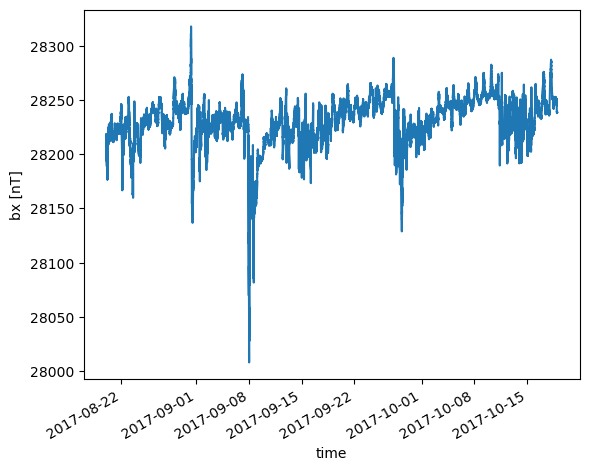

In [29]:
m = mth5.mth5.MTH5()
m.open_mth5(row.path)
ch_df = m.channel_summary.to_dataframe()
start = ch_df.iloc[0].start.isoformat()
#start = (ch_df.iloc[0].start + pd.Timedelta(hours=1)).isoformat()
ch_from_reference = m.from_reference(ch_df.iloc[0].hdf5_reference)
chts = ch_from_reference.to_channel_ts()
print(chts)
chts.plot()
m.close_mth5()

Station SA275 has around 2 months of time series (above)

## 3. Single Station Processing 

#### 3a: Define the source data and stations

In [30]:
# Define files to process
mth5_files = [station_row.path, ]
reference_station_id = None

#### 3b: Define the Transfer Function Kernel Dataset

In [31]:
# Define a RunSummary
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s(mth5_files)
run_summary = mth5_run_summary.clone()
#run_summary.check_runs_are_valid(drop=True)

# Define KernelDataset
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_row.station_id, reference_station_id)

# Add survey and run ID -- this is a workaround for antique mth5 files
kernel_dataset.df["survey"] = "AusLAMP_Musgraves"
kernel_dataset.df["run_id"] = "001"

# Tune up the kernel dataset (not needed in this example)
kernel_dataset.drop_runs_shorter_than(5000)
if len(kernel_dataset.df) == 0:
    print("No RR Coverage, casting to single station processing")
    kernel_dataset.from_run_summary(run_summary, station_row.station_id)

print("Kernel Dataset Dataframe")
kernel_dataset.df

23:11:15T18:47:58 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA300.h5
Kernel Dataset Dataframe


,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path,remote,duration,fc
0,AusLAMP_Musgraves,SA300,001,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,1.0,"[bx, by]","[bz, ex, ey]","{'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...",True,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,False,431999.999999,False


#### 3c: Define the Processing Configuration

In [32]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,
                                       emtf_band_file=BAND_SETUP_PATH.joinpath("bs_six_level.cfg"))
config.channel_nomenclature.keyword = "musgraves"
config.set_default_input_output_channels()
config.set_default_reference_channels()

#### 3d: Process the data

In [33]:
show_plot = False
tf_cls = process_mth5(config,
                      kernel_dataset,
                      units="MT",
                      show_plot=show_plot,
                      )

23:11:15T18:47:58 | INFO | line:281 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
              survey station_id run_id  valid  remote       duration     fc dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0  AusLAMP_Musgraves      SA300    001   True   False  431999.999999  False         0         1.0     1.000000            128.0                 128     431999.0            4499.0
1  AusLAMP_Musgraves      SA300    001   True   False  431999.999999  False         1         4.0     0.250000            512.0                 128     107999.0            1124.0
2  AusLAMP_Musgraves      SA300    001   True   False  431999.999999  False         2         4.0     0.062500           2048.0                 128      26999.0             280.0
3  AusLAMP_Musgraves      SA300    001   True   False  431999.999999  False         3         4.0     0.015625           8192.0                 128

#### 3e: Save the results

In [34]:
xml_file_path_ss = work_path.joinpath(f"{station_row.station_id}_ss.xml")
z_file_ss = str(xml_file_path_ss).replace("xml", "zss")
edi_file_ss = str(xml_file_path_ss).replace("xml", "edi")
tf_cls.write(fn=xml_file_path_ss, file_type="emtfxml")
tf_cls.write(fn=z_file_ss, file_type="zss")
tf_cls.write(fn=edi_file_ss, file_type="edi")

Station: SA300
--------------------------------------------------
	Survey:        0
	Project:       AusLAMP
	Acquired by:   Bruce Goleby
	Acquired date: 2017-08-18
	Latitude:      -26.952
	Longitude:     129.926
	Elevation:     563.000
	Impedance:     True
	Tipper:        True
	Number of periods: 29
		Period Range:   1.17461E+01 -- 2.42352E+04 s
		Frequency Range 4.12623E-05 -- 8.51347E-02 s

## 4. Remote Reference Processing 

#### 4a: Define the source data and stations

**Note** This is the only stage in 4a,b,c,d,e that is not a direct cut and paste from above

In [35]:
# Define files to process
mth5_files = [station_row.path, reference_row.path]
reference_station_id = reference_row.station_id


#### 4b: Define the Transfer Function Kernel Dataset

In [36]:
# Define a RunSummary
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s(mth5_files)
run_summary = mth5_run_summary.clone()
#run_summary.check_runs_are_valid(drop=True)

# Define KernelDataset
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_row.station_id, reference_station_id)

# Add survey and run ID -- this is a workaround for antique mth5 files
kernel_dataset.df["survey"] = "AusLAMP_Musgraves"
kernel_dataset.df["run_id"] = "001"

# Tune up the kernel dataset (not needed in this example)
kernel_dataset.drop_runs_shorter_than(5000)
if len(kernel_dataset.df) == 0:
    print("No RR Coverage, casting to single station processing")
    kernel_dataset.from_run_summary(run_summary, station_row.station_id)

print("Kernel Dataset Dataframe")
kernel_dataset.df

23:11:15T18:48:03 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA300.h5
23:11:15T18:48:03 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA275.h5
Kernel Dataset Dataframe


,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path,remote,duration,fc
0,AusLAMP_Musgraves,SA300,001,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,1.0,"[bx, by]","[bz, ex, ey]","{'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...",True,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,False,431999.999999,False
1,AusLAMP_Musgraves,SA275,001,2017-08-19 00:00:00+00:00,2017-08-23 23:59:59.999999+00:00,1.0,"[bx, by]","[bz, ex, ey]","{'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...",True,/home/kkappler/data/gadi/g/data/my80/AuScope_M...,True,431999.999999,False


**Note:** The kernel dataset identified that there was only a single overlapping time interval of ~5 days between the stations and automatically selected that interval for RR processing

#### 4c: Define the Processing Configuration

In [37]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,
                                       emtf_band_file=BAND_SETUP_PATH.joinpath("bs_six_level.cfg"))
config.channel_nomenclature.keyword = "musgraves"
config.set_default_input_output_channels()
config.set_default_reference_channels()

#### 4d: Process the data

In [38]:
show_plot = False
tf_cls = process_mth5(config,
                      kernel_dataset,
                      units="MT",
                      show_plot=show_plot,
                      )

23:11:15T18:48:03 | INFO | line:281 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
               survey station_id run_id  valid  remote       duration     fc dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   AusLAMP_Musgraves      SA275    001   True    True  431999.999999  False         0         1.0     1.000000            128.0                 128     431999.0            4499.0
1   AusLAMP_Musgraves      SA275    001   True    True  431999.999999  False         1         4.0     0.250000            512.0                 128     107999.0            1124.0
2   AusLAMP_Musgraves      SA275    001   True    True  431999.999999  False         2         4.0     0.062500           2048.0                 128      26999.0             280.0
3   AusLAMP_Musgraves      SA275    001   True    True  431999.999999  False         3         4.0     0.015625           8192.0               

#### 4e: Save the results

In [39]:
xml_file_path_rr = work_path.joinpath(f"{station_row.station_id}_rr.xml")
z_file_rr = str(xml_file_path_rr).replace("xml", "zrr")
edi_file_rr = str(xml_file_path_rr).replace("xml", "edi")
tf_cls.write(fn=xml_file_path_rr, file_type="emtfxml")
tf_cls.write(fn=z_file_rr, file_type="zrr")
tf_cls.write(fn=edi_file_rr, file_type="edi")

Station: SA300
--------------------------------------------------
	Survey:        0
	Project:       AusLAMP
	Acquired by:   Bruce Goleby
	Acquired date: 2017-08-18
	Latitude:      -26.952
	Longitude:     129.926
	Elevation:     563.000
	Impedance:     True
	Tipper:        True
	Number of periods: 29
		Period Range:   1.17461E+01 -- 2.42352E+04 s
		Frequency Range 4.12623E-05 -- 8.51347E-02 s

Note that the TF info can be accessed directly from the tf_cls object returned from processing

In [40]:
tf_cls.transfer_function

<xarray.DataArray 'transfer_function' (period: 29, output: 3, input: 2)>
array([[[-3.49673889e-02-9.71309249e-02j,
          6.40029317e-01+7.65941053e-01j],
        [ 1.29404401e+00+2.34466661e+00j,
          1.43037240e+00+1.14117574e+00j],
        [-2.14089326e-03-1.04261508e-01j,
          1.01465943e-01-1.20186924e-01j]],

       [[-2.00358425e-02-7.43964124e-02j,
          5.93306385e-01+7.03885168e-01j],
        [ 1.13575494e+00+2.03096060e+00j,
          1.23104515e+00+1.19506432e+00j],
        [ 1.60025298e-02-9.52405131e-02j,
          1.06220138e-01-8.95371541e-02j]],

       [[-1.23514262e-02-5.40146318e-02j,
          5.15846282e-01+6.21669323e-01j],
        [ 9.73630155e-01+1.64087015e+00j,
          1.02350695e+00+1.10434279e+00j],
        [ 4.53428182e-02-1.02724457e-01j,
          1.05490299e-01-6.77488320e-02j]],
...
       [[-4.70507950e-03-1.32907641e-02j,
          2.10767397e-02+2.74508023e-02j],
        [ 2.46310673e-02+5.79048545e-02j,
          7.42053451e-02-1.12211034e-02j],
        [ 1.14409899e-01+1.47604809e-02j,
          1.25853589e-01+2.72138529e-02j]],

       [[ 4.11494411e-03-3.22888838e-02j,
         -2.57991540e-02+2.54868297e-02j],
        [-2.42883079e-03-2.55063505e-03j,
          3.14632015e-02+4.72026737e-02j],
        [ 7.47362812e-02-7.18832694e-02j,
          2.17148105e-01+6.37093809e-04j]],

       [[ 7.87391542e-02+1.16439892e-01j,
         -1.47981922e-01+4.87893582e-02j],
        [ 1.97939597e-01-1.03834227e-01j,
          9.03188163e-02+3.44676131e-01j],
        [ 2.33058293e-01-6.62620533e-02j,
          1.27444768e-01+2.99179383e-01j]]])
Coordinates:
  * period   (period) float64 11.75 15.16 19.93 ... 1.668e+04 2.424e+04
  * output   (output) <U2 'ex' 'ey' 'bz'
  * input    (input) <U2 'bx' 'by'
Attributes: (12/14)
    survey:             0
    project:            AusLAMP
    id:                 SA300
    name:               Wataru
    latitude:           -26.95164
    longitude:          129.92562
    ...                 ...
    datum:              None
    acquired_by:        Bruce Goleby
    start:              2017-08-18T01:00:00+00:00
    end:                2017-08-24T20:43:00+00:00
    runs_processed:     ['1']
    coordinate_system:  geomagnetic

## 5. Compare Transfer Functions

#### Compare Single Station vs. Remote Reference

MTData([('SingleStation.SA300',
         TF( survey='SingleStation', station='SA300', latitude=-26.95, longitude=129.93, elevation=563.00 )),
        ('RemoteReference.SA300',
         TF( survey='RemoteReference', station='SA300', latitude=-26.95, longitude=129.93, elevation=563.00 ))])

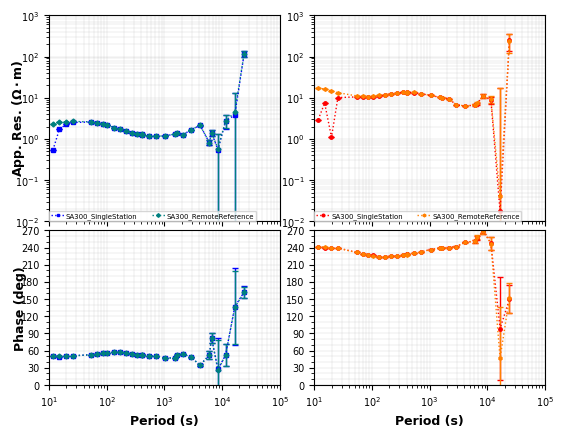

In [41]:
edi_aurora_ss = edi_file_ss
edi_aurora_rr = edi_file_rr
mt_obj_ss = MT(edi_aurora_ss)
mt_obj_ss.read()
mt_obj_rr = MT(edi_aurora_rr)
mt_obj_rr.read()
md = MTData()
md.add_station(mt_obj_ss, survey="SingleStation")
md.add_station(mt_obj_rr, survey="RemoteReference")
md.plot_mt_response(["SingleStation.SA300", "RemoteReference.SA300"], plot_style="compare")
md

**Note:** the only major differences in the case of this clean data are in the dead band.

#### Compare Aurora vs BIRRP

MTData([('aurora.SA300',
         TF( survey='aurora', station='SA300', latitude=-26.95, longitude=129.93, elevation=563.00 )),
        ('birrp.SAA300',
         TF( survey='birrp', station='SAA300', latitude=-26.95, longitude=129.93, elevation=563.00 ))])

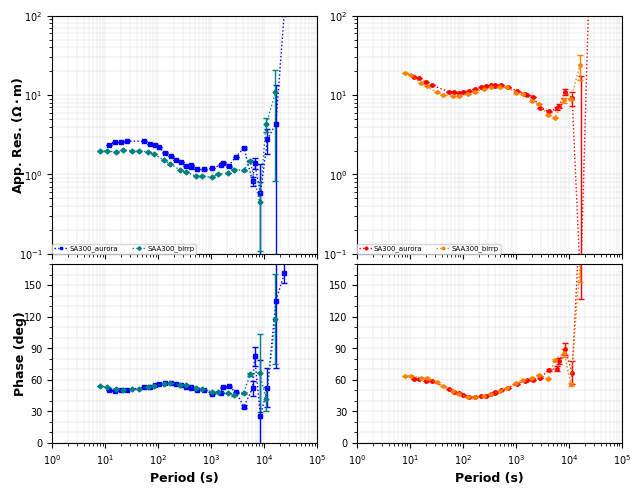

In [42]:
edi_aurora_rr = edi_file_rr
edi_birrp = musgraves_edis_path.joinpath("SA300.edi")
mt_obj_aurora = MT(edi_aurora_rr)
mt_obj_aurora.read()
mt_obj_aurora.flip_phase(zyx=True, inplace=True)
mt_obj_birrp = MT(edi_birrp)
mt_obj_birrp.read()
md = MTData()
md.add_station(mt_obj_aurora, survey="aurora")
md.add_station(mt_obj_birrp, survey="birrp")
md.plot_mt_response(["aurora.SA300", "birrp.SAA300"], plot_style="compare")
md

## 6. HPC

There are many ways to parallelize.  Here is one example that uses a very simple model and leverages the embarassignly parallelizable nature of processing
many stations.

In this case we will use "pandarallel" to loop over the available stations

In [43]:
availability_df = get_musgraves_availability_df(data_dir)

Found 6 h5 files


In [44]:
def enrich_row_with_processing(row):
    mth5_files = [row.path,]
    print("path", row.path, "type", type(row.path))
    my_h5 = pathlib.Path(row.path)
    print(f"{my_h5.exists()} my_h5.exists()")
    xml_file_path = RESULTS_PATH.joinpath(f"{row.station_id}.xml")
    print(xml_file_path)
    
    try:
        mth5_run_summary = RunSummary()
        mth5_run_summary.from_mth5s(mth5_files)
        run_summary = mth5_run_summary.clone()
        #run_summary.check_runs_are_valid(drop=True)
        kernel_dataset = KernelDataset()
        kernel_dataset.from_run_summary(run_summary, row.station_id, None)
    
        # Antique mth5 workaround
        kernel_dataset.df["survey"] = "AusLAMP_Musgraves"
        kernel_dataset.df["run_id"] = "001"
        #print(kernel_dataset.df)
        
        # kernel_dataset.drop_runs_shorter_than(5000)
        # if len(kernel_dataset.df) == 0:
        #     print("No RR Coverage, casting to single station processing")
        #     kernel_dataset.from_run_summary(run_summary, row.station_id)

        cc = ConfigCreator()
        config = cc.create_from_kernel_dataset(kernel_dataset,)
#                                               emtf_band_file=BANDS_TEST_FAST_FILE)
        config.channel_nomenclature.keyword = "musgraves"
        config.set_default_input_output_channels()
        show_plot = False
              
        z_file = str(xml_file_path).replace("xml", "zss")
        tf_cls = process_mth5(config,
                              kernel_dataset,
                              units="MT",
                              show_plot=show_plot,
                              z_file_path=z_file,
                              )
        tf_cls.write(fn=xml_file_path, file_type="emtfxml")
        # consider add xml_file_path.timestamp to columns??
    except Exception as e:
        row.exception = e.__class__.__name__
        row.error_message = e.args[0]
    return row

In [45]:
def process_lots_of_mth5s(df, use_pandarallel=False):
    """

    Parameters
    ----------
    df : pd.DataFrame
        This is a list of the files

    Returns
    -------
    df:  pd.DataFrame
        Same as input but with new columns

    """
    df["exception"] = ""
    df["error"] = ""
    if use_pandarallel:
        from pandarallel import pandarallel
        pandarallel.initialize(verbose=3)
        enriched_df = df.parallel_apply(enrich_row_with_processing, axis=1)
    else:
        print("NO PANDARALEL")
        #return None
        enriched_df = df.apply(enrich_row_with_processing, axis=1)

    return enriched_df

In [46]:
enriched_df = process_lots_of_mth5s(availability_df, use_pandarallel=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
pathpathpathpath  pathpath  /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA275.h5/home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA225-2.h5 /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA349.h5  /home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/WANT38.h5/home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/SA/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA300.h5  /home/kkappler/data/gadi/g/data/my80/AuSco

NameError: name 'RESULTS_PATH' is not defined

In [ ]:
enriched_df

In [ ]:
enriched_df.exception.unique()

<div class="alert alert-block alert-danger">
<b>TODO:</b> Deduce RR Pairings
</div>